# Structural Estimation of the Buffer-Stock Model

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb
from scipy.optimize import minimize
from mpl_toolkits import mplot3d

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Buffer-Stock Consumption-Saving Model

In [2]:
# load local model file and initialize model class
from BufferStockModel import BufferStockModelClass
model = BufferStockModelClass()

## Solve the model

In [3]:
model.solve()
par = model.par
sol = model.sol

**Last period, $t=T-1$**

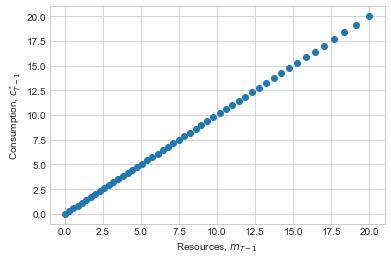

In [4]:
# last period consumption
t = par.T-1
fig, ax = plt.subplots()
ax.scatter(par.m_grid,sol.c[t,:])
ax.set(xlabel='Resources, $m_{T-1}$',ylabel='Consumption, $c_{T-1}^{\star}$');

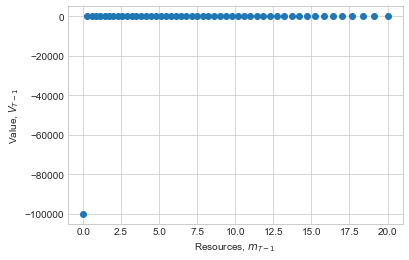

In [5]:
fig, ax = plt.subplots()
ax.scatter(par.m_grid,sol.V[t,:])
ax.set(xlabel='Resources, $m_{T-1}$',ylabel='Value, $V_{T-1}$');

**Question 1:** Why does the value function look like this? <br> \[*hint:* try plotting all but the first point in the grid.\]

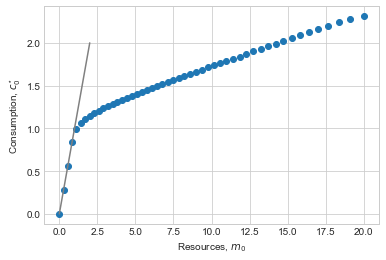

In [6]:
t = 0
fig, ax = plt.subplots()
ax.scatter(par.m_grid,sol.c[t,:])
ax.plot([0,2],[0,2],color='gray')
ax.set(xlabel='Resources, $m_{0}$',ylabel='Consumption, $c_{0}^{\star}$');

## In-class exercise

1. Look at the code and talk about it with the person next to you for 5 minutes
2. Write at least one question

## Simulation
UPDATE!
With the solution at hand we can now simulate `simN` synthetic individuals for `simT` periods. We do so by initializing all state-variables in the first period and simulate forwards. 

Initial wealth is the only state variable in our model, and we start by initilizing all individuals with no wealth, `sim.a_init=np.zeros(par.simN)`. We then loop forward using the solution:
$$
\begin{align}
c_{i,t} &= c_t^{\star}(a_{i,t}) \\
a_{i,t+1} &= (1+r)(a_{i,t} + y_{i,t} - c_{i,t})
\end{align}
$$

In [7]:
model.simulate()
sim = model.sim

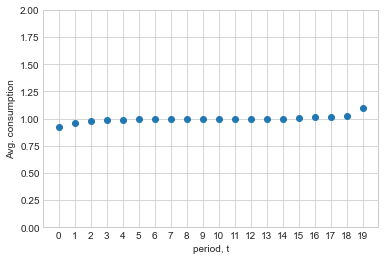

In [8]:
fig, ax = plt.subplots()
ax.scatter(range(par.simT),np.mean(sim.c,axis=0))
ax.set(xlabel='period, t',ylabel='Avg. consumption',ylim=[0,2],xticks=range(par.simT));

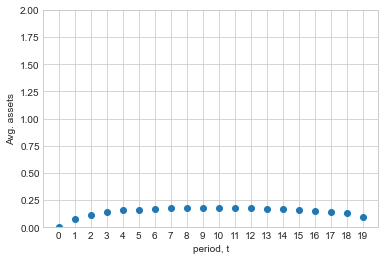

In [9]:
fig, ax = plt.subplots()
ax.scatter(range(par.simT),np.mean(sim.a,axis=0))
ax.set(xlabel='period, t',ylabel='Avg. assets',ylim=[0,2],xticks=range(par.simT));

**Question 2:** 

**Question 3:** 
**Question 4:** 

## In-class exercise

1. Look at the code and talk about it with the person next to you for 5 minutes
2. Write at least one question

## Structural Estimation of $\theta=(\beta,\rho)$

In [10]:
def obj_func(theta,theta_names,data,model,do_print=False):
    
    if do_print: print(theta)
        
    # update parameters
    for i,name in enumerate(theta_names):
        setattr(model.par,name,theta[i])
    
    # solve and simulate model with these parameters
    model.solve()
    model.simulate()
    
    # calculate moments in data and simulation
    mom_sim = moment_func(model.sim)
    mom_dat = moment_func(data)
    
    # equal weighting
    obj = np.sum((mom_dat - mom_sim)**2)
    
    # return objective and moments for plotting
    return obj, mom_sim, mom_dat

def moment_func(data):
    return np.mean(data.A,axis=0) # age profile of wealth

In [11]:
# simulate synthetic data with a known set of parameters. 
beta_true = 0.98
rho_true = 2.0

data_model = BufferStockModelClass(par={'beta':beta_true,'rho':rho_true})

data_model.solve()
data_model.simulate()

data = data_model.sim

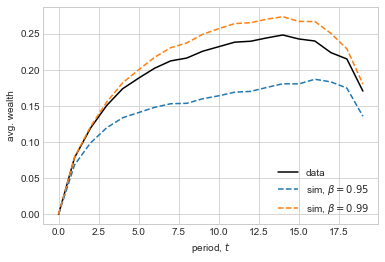

In [12]:
# Plot the different age-profiles for different values of, say, beta. the profiles are the 2.and 3. ourput from obj_func
_,mom_sim_95,mom_dat = obj_func(np.array([0.95]),('beta',),data,model)
_,mom_sim_99,mom_dat = obj_func(np.array([0.99]),('beta',),data,model)

fig, ax = plt.subplots()
ax.plot(range(par.simT),mom_dat,label='data',color='black')
ax.plot(range(par.simT),mom_sim_95,linestyle='--',label=r'sim, $\beta=0.95$')
ax.plot(range(par.simT),mom_sim_99,linestyle='--',label=r'sim, $\beta=0.99$')
ax.set(xlabel='period, $t$',ylabel='avg. wealth')
ax.legend();

In [13]:
# evaluate objective function at truth.
# Because the seed is the same, the objective function is exactly zero.
theta_names = ('beta','rho')
theta = np.array([beta_true,rho_true])
obj_true = obj_func(theta,theta_names,data,model)[0]
obj_true

0.0

In [14]:
# plot objective function 
beta_grid = np.linspace(0.95,1.0,7)
rho_grid = np.linspace(1.5,2.5,7)

obj = np.nan + np.ones((beta_grid.size,rho_grid.size))
for ibeta,beta in enumerate(beta_grid):
    for irho,rho in enumerate(rho_grid):
        theta = [beta,rho]
        obj[ibeta,irho] = obj_func(theta,theta_names,data,model)[0]

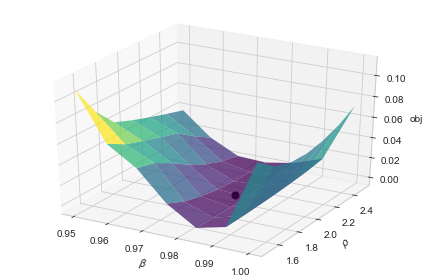

In [15]:
fig = plt.figure()
ax = plt.axes(projection='3d')

X, Y = np.meshgrid(beta_grid, rho_grid,indexing='ij')
Z = obj

ax.plot_surface(X, Y, Z,rstride=1,cstride=1,cmap='viridis', edgecolor='none',alpha=0.75);
ax.scatter(beta_true,rho_true,obj_true,color='black',s=50)
ax.set(xlabel=r'$\beta$',ylabel=r'$\rho$',zlabel='obj');
plt.tight_layout()

In [16]:
# call numerical optimizer
objective = lambda theta: obj_func(theta,theta_names,data,model,do_print=True)[0]

theta_init = np.array([beta_true,rho_true]) * 0.98
bounds = ((0.95,1.0),(1.5,2.5))

res = minimize(objective,theta_init,bounds=bounds)
res

[0.9604 1.96  ]
[0.96040001 1.96      ]
[0.9604     1.96000001]
[1.  1.5]
[0.99999999 1.5       ]
[1.         1.50000001]
[0.98309109 1.69641663]
[0.9830911  1.69641663]
[0.98309109 1.69641664]
[0.99868975 1.72325341]
[0.99868976 1.72325341]
[0.99868975 1.72325342]
[0.98313252 1.6964879 ]
[0.98313253 1.6964879 ]
[0.98313252 1.69648791]
[0.99091113 1.70987066]
[0.99091114 1.70987066]
[0.99091113 1.70987067]
[0.98386062 1.69774057]
[0.98386063 1.69774057]
[0.98386062 1.69774058]
[0.98346679 1.69706301]
[0.9834668  1.69706301]
[0.98346679 1.69706302]
[0.98323747 1.69666847]
[0.98323748 1.69666847]
[0.98323747 1.69666848]
[0.98316537 1.69654441]
[0.98316538 1.69654441]
[0.98316537 1.69654442]
[0.98314757 1.69651381]
[0.98314758 1.69651381]
[0.98314757 1.69651382]
[0.98313684 1.69649534]
[0.98313685 1.69649534]
[0.98313684 1.69649535]
[0.98313252 1.6964879 ]
[0.98313253 1.6964879 ]
[0.98313252 1.69648791]
[1.         1.74723347]
[0.99999999 1.74723347]
[1.         1.74723348]
[0.98991674 1.

      fun: 1.4108640789267633e-05
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.03698081, -0.11763112])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 78
      nit: 3
     njev: 26
   status: 0
  success: True
        x: array([0.98313258, 1.69648808])